In [1]:
import pandas as pd 
df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [2]:
df.groupby("Category").describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [3]:
df.describe()

,Category,Message
count,5572,5572
unique,2,5157
top,ham,"Sorry, I'll call later"
freq,4825,30


In [4]:
df["Category"].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [5]:
747/4825

0.15481865284974095

In [6]:
df_spam = df[df["Category"]=="spam"]
df_spam.shape

(747, 2)

In [7]:
df_ham = df[df["Category"]=="ham"]
df_ham.shape

(4825, 2)

In [8]:
ham_downsampled=df_ham.sample(df_spam.shape[0])
ham_downsampled.shape

(747, 2)

In [9]:
df_balanced = pd.concat([df_spam,ham_downsampled])
df_balanced.shape

(1494, 2)

In [10]:
df_balanced["Category"].value_counts()

spam    747
ham     747
Name: Category, dtype: int64

In [11]:
df_balanced.sample(5)

,Category,Message
225,spam,"500 New Mobiles from 2004, MUST GO! Txt: NOKIA..."
1893,spam,CALL 09090900040 & LISTEN TO EXTREME DIRTY LIV...
1407,spam,"URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD..."
1640,spam,FreeMsg:Feelin kinda lnly hope u like 2 keep m...
1334,ham,"Oh... Icic... K lor, den meet other day..."


In [12]:
df_balanced['spam'] = df_balanced["Category"].apply(lambda x:1 if x=="spam" else 0 )
df_balanced.sample(10)

,Category,Message,spam
4500,spam,"SMS SERVICES. for your inclusive text credits,...",1
2558,spam,This message is brought to you by GMW Ltd. and...,1
12,spam,URGENT! You have won a 1 week FREE membership ...,1
3766,spam,Someone U know has asked our dating service 2 ...,1
911,ham,My love ! How come it took you so long to leav...,0
1227,spam,Reply with your name and address and YOU WILL ...,1
3988,spam,Ringtone Club: Gr8 new polys direct to your mo...,1
5436,ham,Mode men or have you left.,0
1086,ham,FR'NDSHIP is like a needle of a clock. Though ...,0
3587,spam,I am hot n horny and willing I live local to y...,1


In [13]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(df_balanced['Message'],df_balanced['spam'],stratify=df_balanced['spam'])

In [14]:
x_train.head()

1789                          Arun can u transfr me d amt
3715    Oh, i will get paid. The most outstanding one ...
5468    URGENT! Last weekend's draw shows that you hav...
5140    Yeah I imagine he would be really gentle. Unli...
4386    Do you want a New Nokia 3510i Colour Phone Del...
Name: Message, dtype: object

In [15]:
import tensorflow_hub as hub
import tensorflow_text as text

In [16]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("p")

In [19]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']
get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin,are you up for a volleyball game tomorrow"
])

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.843517  , -0.5132726 , -0.88845736, ..., -0.7474886 ,
        -0.7531473 ,  0.91964483],
       [-0.86342764, -0.5988452 , -0.9751755 , ..., -0.9111035 ,
        -0.7261738 ,  0.8519892 ]], dtype=float32)>

In [21]:
e = get_sentence_embeding([
    'banana',
    "grapes",
    "jeff bezos",
    "elon musk",
    "bill gates"
])
e

<tf.Tensor: shape=(5, 768), dtype=float32, numpy=
array([[-0.7606918 , -0.14219387,  0.49604616, ...,  0.4216532 ,
        -0.5322141 ,  0.8031218 ],
       [-0.86023223, -0.21242969,  0.4915688 , ...,  0.3979803 ,
        -0.60506296,  0.8447165 ],
       [-0.8253347 , -0.3555059 , -0.5906972 , ..., -0.01613772,
        -0.61417586,  0.872303  ],
       [-0.75041336, -0.26812622, -0.26689738, ...,  0.02839335,
        -0.5938098 ,  0.7974988 ],
       [-0.78544384, -0.2994968 ,  0.41027433, ...,  0.5222542 ,
        -0.4957357 ,  0.8150752 ]], dtype=float32)>

In [29]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[2]],[e[3]])

array([[0.9872035]], dtype=float32)

In [31]:
import tensorflow as tf

In [36]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [38]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [45]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [46]:
len(x_train)

1120

In [47]:
model.fit(x_train, y_train, epochs=1)

35/35 [==============================] - 665s 19s/step - loss: 0.6422 - accuracy: 0.6393 - precision: 0.6423 - recall: 0.6286


In [50]:
model.evaluate(x_test,y_test)

12/12 [==============================] - 221s 18s/step - loss: 0.5459 - accuracy: 0.8770 - precision: 0.8507 - recall: 0.9144


[0.545894205570221, 0.8770053386688232, 0.8507462739944458, 0.9144384860992432]

In [53]:
y_predicted= model.predict(x_test)
y_predicted= y_predicted.flatten()

In [54]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
cm=confusion_matrix(y_test,y_predicted)
cm

array([[157,  30],
       [ 16, 171]], dtype=int64)

Text(33.0, 0.5, 'Truth')

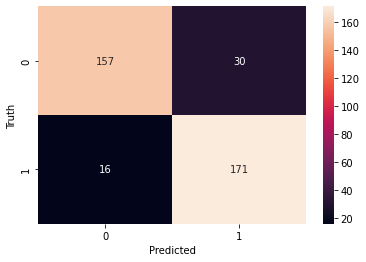

In [56]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [57]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.91      0.84      0.87       187
           1       0.85      0.91      0.88       187

    accuracy                           0.88       374
   macro avg       0.88      0.88      0.88       374
weighted avg       0.88      0.88      0.88       374



In [58]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.6040272 ],
       [0.592866  ],
       [0.60852796],
       [0.43705493],
       [0.40150517]], dtype=float32)